The [OpenAI to Z Challenge](https://www.kaggle.com/competitions/openai-to-z-challenge/data) has six recommended satellite imagery and map sources:
- Google Earth Engine (GEE)
    - Sentinel-1
    - Sentinel-2
    - NICFI
    - GEDI
    - SRTM
    -Landsat
- European Space Agency
- NASA
- OpenTopography LiDAR
- Sentinel-2 optical imagery
- AWS CLI

In this notebook I will build a pipeline to download and visualise GEE LiDAR Sentinel-2. In a separate notebook I will do the same for OpenTopography LiDAR (1m if possible).

In [4]:
import os
import importlib.util
import geemap
import sys
import subprocess
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pydrive
import ee

In [5]:
# ee.Authorize()
ee.Initialize(project="ee-jamesbyers92")

In [8]:
# Example AOI in southwestern Amazon (adjust as needed)
aoi = ee.Geometry.BBox(-63.0, -11.0, -62.5, -10.5)

# Two time windows
date1_start, date1_end = "2016-06-01", "2016-09-01"
date2_start, date2_end = "2022-06-01", "2022-09-01"

def get_s2_composite(start, end):
    collection = (
        ee.ImageCollection("COPERNICUS/S2_SR")
        .filterBounds(aoi)
        .filterDate(start, end)
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
    )
    return collection.median().clip(aoi).select(['B4', 'B3', 'B2'])  # RGB

image_2016 = get_s2_composite(date1_start, date1_end)
image_2022 = get_s2_composite(date2_start, date2_end)

def export_image(image, name):
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=f"{name}_export",
        folder="GEE_exports",
        fileNamePrefix=name,
        region=aoi,
        scale=10,
        maxPixels=1e9
    )
    task.start()
    print(f"Started export task: {name}")

export_image(image_2016, "amazon_2016_rgb")
export_image(image_2022, "amazon_2022_rgb")


/Users/jamesbyers/code/github/Kaggle/openai_to_z/venv/lib/python3.12/site-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


Started export task: amazon_2016_rgb
Started export task: amazon_2022_rgb


In [29]:
import os
print(os.getcwd())
print(os.listdir())  # Confirm 'client_secrets.json' is listed

/Users/jamesbyers/code/github/Kaggle/openai_to_z
['LICENSE', 'scratch_code', 'README.md', '.gitignore', 'openai_log.jsonl', 'venv', '.git', 'data', 'outputs', 'notebooks', 'client_secrets.json']


In [6]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

gauth = GoogleAuth()

# Explicitly use the downloaded JSON file
gauth.settings['client_config_backend'] = 'file'
gauth.settings['client_config_file'] = 'client_secrets.json'

# Start authentication
gauth.LocalWebserverAuth()

# Save credentials
gauth.SaveCredentialsFile("mycreds.txt")

# Create drive instance
drive = GoogleDrive(gauth)


Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=705704262892-pkd5k5273gsqdbulfvdor03c6ghsvr1v.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [7]:
if gauth.credentials is None:
    gauth.LocalWebserverAuth()          # Will use client_secrets.json
elif gauth.access_token_expired:
    gauth.Refresh()
else:
    gauth.Authorize()

gauth.SaveCredentialsFile("mycreds.txt")
drive = GoogleDrive(gauth)

In [8]:
# List all .tif files in your Drive (you can refine this later by folder)
file_list = drive.ListFile({'q': "title contains '.tif'"}).GetList()

for file in file_list:
    print(f"{file['title']} (ID: {file['id']})")


amazon_2022_rgb.tif (ID: 1YVBuj3KTiK8PR1U_hPFE8cywmWSKy_PK)
s2_may_2023_rgb.tif (ID: 1pW8_tJDTGgVdrBGuRWnN1QFSbtAyfu0w)


In [10]:
import os
os.makedirs("data/raw", exist_ok=True)

# Download each file
for file in file_list:
    local_path = os.path.join("data/raw", file['title'])
    print(f"Downloading {file['title']} to {local_path}")
    file.GetContentFile(local_path)


In [11]:
# List your downloaded files
tif_files = [f for f in os.listdir("data/raw") if f.endswith(".tif")]
print("Found:", tif_files)

Found: ['amazon_2022_rgb.tif', 's2_may_2023_rgb.tif']


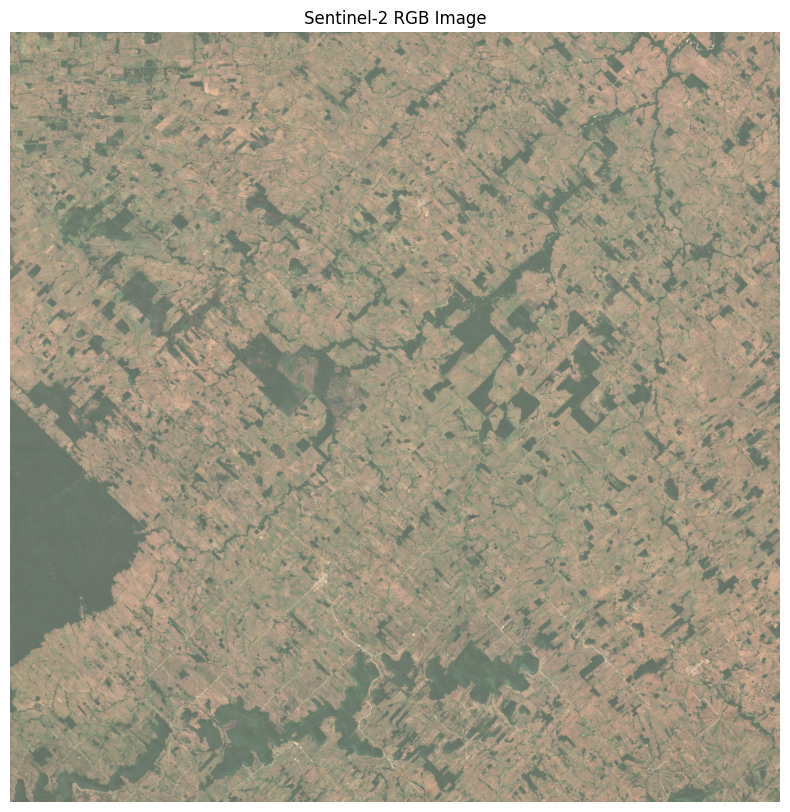

In [12]:
# Load image
file_path = os.path.join("data/raw", "amazon_2022_rgb.tif")  # change to match your filename

with rasterio.open(file_path) as src:
    img = src.read([1, 2, 3])  # Read RGB bands

# Sentinel-2 is stored as reflectance, typically 0–3000, so we scale
img_norm = np.clip(img / 3000, 0, 1)  # Scale to 0–1 for display
img_norm = np.transpose(img_norm, (1, 2, 0))  # reshape to (H, W, C)

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(img_norm)
plt.axis('off')
plt.title("Sentinel-2 RGB Image")
plt.show()

In [14]:
from PIL import Image

# Convert float32 [0, 1] array to uint8 [0, 255]
img_uint8 = (img_norm * 255).astype(np.uint8)

# Save as PNG
Image.fromarray(img_uint8).save("data/derived/amazon_2022_rgb.png")

In [16]:
import openai
from pathlib import Path
import base64

openai.api_key = os.getenv("OPENAI_API_KEY_openai_to_z")

# Path to your image
image_path = "data/derived/amazon_2022_rgb.png"

# Encode the image to base64
with open(image_path, "rb") as image_file:
    image_data = base64.b64encode(image_file.read()).decode('utf-8')

# Create the data URI
image_data_uri = f"data:image/png;base64,{image_data}"

# Send the image to GPT-4o
response = openai.chat.completions.create(
    model="gpt-4o",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What environmental changes can you observe from this Sentinel-2 image?"},
                {"type": "image_url", "image_url": {"url": image_data_uri}}
            ]
        }
    ],
    max_tokens=1000
)

# Print the response
print(response.choices[0].message.content)

The Sentinel-2 image shows several observable environmental changes:

1. **Deforestation**: Large areas appear to have been cleared, likely for agriculture or urban development. This is evident from the patchy landscape with irregular shapes indicating land conversion.

2. **Fragmentation**: The landscape is highly fragmented, with remaining forest areas appearing isolated. This can impact biodiversity by reducing habitat connectivity.

3. **Agricultural Expansion**: The patterns of cleared land suggest agricultural fields, indicating expansion of farming activities.

4. **Water Bodies**: Some areas show water bodies, which might have reduced vegetation around them, potentially affecting aquatic ecosystems.

5. **Urbanization**: There might be some indications of urban development, noticeable by grid-like patterns typical of roads or urban planning.

These changes can have significant impacts on local ecosystems, biodiversity, and climate.


In [65]:
import requests
import numpy as np
import json

def query_opentopo_raw(lat, lon, radius_m=2000):
    delta_lat = radius_m / 111320
    delta_lon = radius_m / (111320 * abs(np.cos(np.radians(lat))))

    url = "https://portal.opentopography.org/API/otCatalog"
    params = {
        "south": lat - delta_lat,
        "north": lat + delta_lat,
        "west": lon - delta_lon,
        "east": lon + delta_lon,
        "outputFormat": "json"
    }

    print(f"Querying OpenTopography raw data near ({lat}, {lon})...")
    response = requests.get(url, params=params)
    if response.status_code != 200:
        print(f"Request failed: {response.status_code}")
        return None

    data = response.json()
    datasets = data.get("Datasets", [])
    print(f"Found {len(datasets)} entries.")
    return datasets


In [68]:
# datasets = query_opentopo_raw(41.2132, -124.0046)  # Redwoods
datasets = query_opentopo_raw(-59.3228, -9.4150)  # Redwoods

# Show first 1–2 entries in full
for i, item in enumerate(datasets[:2]):
    print(f"\n--- Dataset {i+1} ---")
    print(json.dumps(item, indent=2))


Querying OpenTopography raw data near (-59.3228, -9.415)...
Found 1072 entries.

--- Dataset 1 ---
{
  "Dataset": {
    "name": "Auckland Part 1, New Zealand 2024",
    "identifier": {
      "@type": "PropertyValue",
      "propertyID": "opentopoID",
      "value": "OTLAS.042025.2193.1"
    },
    "alternateName": "NZ24_Auckland",
    "url": "https://doi.org/10.5069/G9HH6H8T",
    "fileFormat": "Point Cloud Data",
    "dateCreated": "2025-04-16",
    "temporalCoverage": "2024-04-30 / 2024-06-27",
    "spatialCoverage": {
      "@type": "Place",
      "additionalProperty": [
        {
          "@type": "PropertyValue",
          "additionalType": "CoordinatesSystem",
          "name": "Horizontal Coordinates",
          "value": "NZTM2000 NZGD2000 Meters"
        },
        {
          "@type": "PropertyValue",
          "additionalType": "CoordinatesSystem",
          "name": "Vertical Coordinates",
          "value": "NZVD2016"
        },
        {
          "@type": "PropertyValue",

In [69]:
def extract_usable_datasets(raw_results, max_results=20):
    usable = []

    for i, item in enumerate(raw_results):
        dataset = item.get("Dataset")
        if not dataset:
            continue

        name = dataset.get("name")
        ds_id = dataset.get("identifier", {}).get("value")
        doi = dataset.get("url")

        if name and ds_id and doi:
            usable.append({
                "name": name,
                "id": ds_id,
                "doi": doi
            })

    print(f"🟢 Found {len(usable)} usable datasets")
    for entry in usable[:max_results]:
        print(f"- {entry['name']} → {entry['doi']}")

    return usable


In [70]:
raw = query_opentopo_raw(41.2132, -124.0046)
usable = extract_usable_datasets(raw)


Querying OpenTopography raw data near (41.2132, -124.0046)...
Found 1072 entries.
🟢 Found 1072 usable datasets
- Auckland Part 1, New Zealand 2024 → https://doi.org/10.5069/G9HH6H8T
- Medium Resolution Digital Elevation Model of Canada → https://doi.org/10.5069/G9N8780J
- Waikato, New Zealand 2024 → https://doi.org/10.5069/G91J980G
- Preliminary Digital Elevation Models for Palisades Fire, CA 2025 → https://doi.org/10.5069/G9DR2SPG
- Preliminary Digital Elevation Models for Eaton Fire, CA 2025 → https://doi.org/10.5069/G9JH3JD6
- Manawat&#363; - Whanganui, New Zealand 2024 → https://doi.org/10.5069/G9P8494X
- Northland, New Zealand 2024 → https://doi.org/10.5069/G9XS5SN5
- Mobile Laser Scan over Ridgecrest, CA 2019 → https://doi.org/10.5069/G99Z933C
- Photogrammetric Survey over Ridgecrest, CA 2018 → https://doi.org/10.5069/G9FQ9TT9
- Lidar Survey over San Andreas Fault, CA 2017 → https://doi.org/10.5069/G9KH0KJK
- Hawkes Bay, New Zealand 2023 - 2024 → https://doi.org/10.5069/G9Q81B9R